In [1]:
import torch
import configuration
import tsaug
from utils import *
from configuration import *
import numpy as np
from utils.Loader import CustomDataset

In [2]:
args = parser.parse_args([])
args.DEVICE = 'cpu'
args.task = 'temporal'
args.metric = 'temporal_acc'
args.augment = True
args.SoftEva = True
args.augment = True
args.DATASET = 1
args = FormulateArgs(args)

In [3]:
args.augment

True

In [4]:
train_loader , datainfo = GetDataLoader(args, 'train',)

In [5]:
datainfo

{'dataname': 'distalphalanxtw',
 'N_feature': 1,
 'N_class': 6,
 'N_time': 64,
 'N_train': 300,
 'N_valid': 100,
 'N_test': 100}

In [6]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
--------------- True
-------------

In [8]:
import torch
import numpy as np

@staticmethod
def time_warping(batch_time_series, warp_factor):
    """Apply random time warping to a batch of multivariate time series data."""
    # Assume batch_time_series is of shape (B, D, T)
    B, D, T = batch_time_series.size()

    # Generate the original time points
    time_points = torch.arange(T, device=batch_time_series.device, dtype=torch.float).repeat(B, D, 1)  # Shape: (B, D, T)

    # Generate random warping factors for each time series in the batch
    random_factors = torch.tensor(np.random.uniform(1 - warp_factor, 1 + warp_factor, size=(B, D, 1)), device=batch_time_series.device)

    # Generate warped time points
    warped_time_points = time_points * random_factors

    # Ensure warped time points are within bounds
    warped_time_points = torch.clamp(warped_time_points, 0, T - 1)

    # Perform linear interpolation manually for each time series and each feature
    lower_indices = torch.floor(warped_time_points).long()  # Lower indices for interpolation
    upper_indices = torch.ceil(warped_time_points).long()  # Upper indices for interpolation
    upper_indices = torch.clamp(upper_indices, max=T - 1)  # Ensure indices are within valid range

    # Calculate interpolation weights
    lower_weights = (upper_indices.float() - warped_time_points)  # Weight for lower indices
    upper_weights = (warped_time_points - lower_indices.float())  # Weight for upper indices

    # Gather time series values for interpolation
    batch_time_series_warped = (lower_weights * batch_time_series.gather(2, lower_indices) +
                                upper_weights * batch_time_series.gather(2, upper_indices))

    return batch_time_series_warped


In [14]:
def jittering(time_series, noise_level):
    """Add Gaussian noise to the time series data.
    
    Args:
        time_series (torch.Tensor): The input time series data of shape (B, D, T).
        noise_level (float): The standard deviation of the Gaussian noise.
        
    Returns:
        torch.Tensor: The time series data with added Gaussian noise.
    """
    # Generate Gaussian noise with the same shape and device as the input time series
    noise = torch.normal(mean=0, std=noise_level, size=time_series.shape, device=time_series.device)

    # Add the noise to the time series data
    return time_series + noise

In [21]:
def magnitude_scaling(time_series, scaling_factor_range):
    """Randomly scale the magnitude of the time series data.
    
    Args:
        time_series (torch.Tensor): The input time series data of shape (B, D, T).
        scaling_factor_range (tuple): A tuple specifying the range (min, max) 
                                    from which to draw the random scaling factor.
        
    Returns:
        torch.Tensor: The time series data scaled by the random factor.
    """
    # Generate a random scaling factor from the specified range for each time series in the batch
    B, D, T = time_series.shape  # Get the shape of the time series data
    scaling_factors = torch.tensor(
        np.random.uniform(*scaling_factor_range, size=(B, 1, 1)),
        device=time_series.device, dtype=time_series.dtype
    )

    # Scale each time series by its corresponding random scaling factor
    return time_series * scaling_factors

In [27]:
import torch
import numpy as np

@staticmethod
def random_cropping(batch_time_series, crop_size):
    """Randomly crop the time series data along the time dimension.
    
    Args:
        batch_time_series (torch.Tensor): The input time series data of shape (B, D, T).
        crop_size (int): The desired number of time steps after cropping.
        
    Returns:
        torch.Tensor: The cropped time series data of shape (B, D, crop_size).
    """
    B, D, T = batch_time_series.shape

    # Ensure crop size is not greater than the number of time steps
    if crop_size > T:
        raise ValueError("crop_size must be less than or equal to the number of time steps (T).")

    # Generate random start points for cropping for each sample in the batch
    start_indices = np.random.randint(0, T - crop_size + 1, size=B)

    # Initialize an empty tensor for cropped time series
    cropped_series = torch.empty((B, D, crop_size), device=batch_time_series.device, dtype=batch_time_series.dtype)

    # Perform cropping for each time series in the batch
    for i in range(B):
        start = start_indices[i]
        cropped_series[i] = batch_time_series[i, :, start:start + crop_size]

    return cropped_series


In [32]:
import torch

@staticmethod
def frequency_domain_augmentation(time_series, noise_level):
    """Add noise in the frequency domain to the time series data.
    
    Args:
        time_series (torch.Tensor): The input time series data of shape (B, D, T).
        noise_level (float): The standard deviation of the Gaussian noise to be added in the frequency domain.
        
    Returns:
        torch.Tensor: The augmented time series data of shape (B, D, T).
    """
    # Compute the FFT of the time series along the time dimension
    fft_series = torch.fft.fft(time_series, dim=-1)

    # Generate Gaussian noise in the frequency domain with the same shape and device as fft_series
    noise = torch.normal(mean=0, std=noise_level, size=fft_series.shape, device=fft_series.device, dtype=fft_series.dtype)

    # Add the noise to the FFT of the time series
    augmented_fft = fft_series + noise

    # Perform the inverse FFT to get the augmented time series
    augmented_series = torch.fft.ifft(augmented_fft, dim=-1)

    # Return only the real part since the time series should be real-valued
    return augmented_series.real


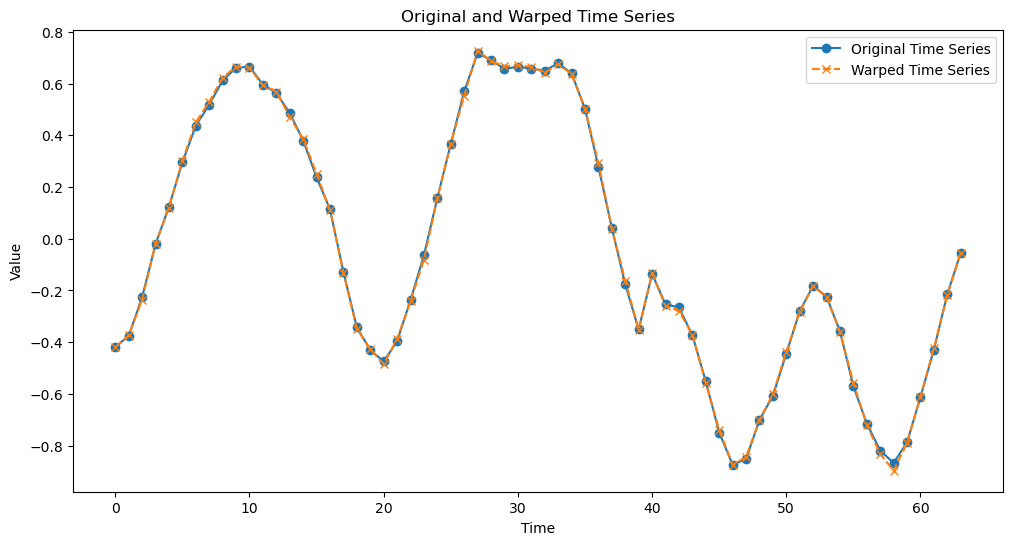

In [37]:
import matplotlib.pyplot as plt
# Apply time warping to the tensor x
warped_x = frequency_domain_augmentation(x,noise_level=0.1)

# Select a sample index for demonstration
sample_index = 0

# Convert tensors to numpy for plotting
original_series = x[sample_index].numpy()
warped_series = warped_x[sample_index].numpy()

# Plot the original and warped time series
plt.figure(figsize=(12, 6))
# Original Time Series
plt.plot(original_series.T, label='Original Time Series', linestyle='-', marker='o')
# Warped Time Series
plt.plot(warped_series.T, label='Warped Time Series', linestyle='--', marker='x')
plt.legend()
plt.title('Original and Warped Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

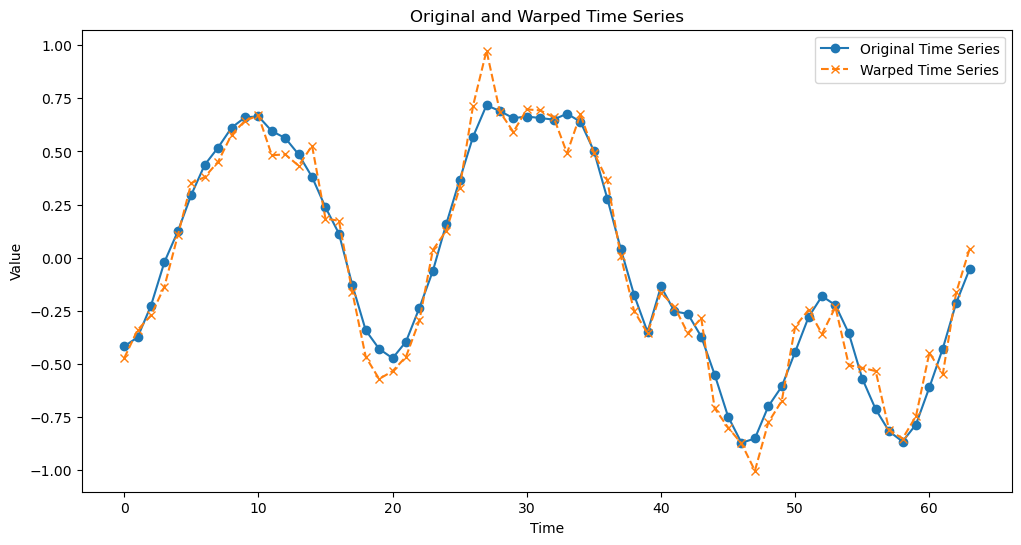

In [15]:
import matplotlib.pyplot as plt
# Apply time warping to the tensor x
warped_x = jittering(x, 0.1)

# Select a sample index for demonstration
sample_index = 0

# Convert tensors to numpy for plotting
original_series = x[sample_index].numpy()
warped_series = warped_x[sample_index].numpy()

# Plot the original and warped time series
plt.figure(figsize=(12, 6))
# Original Time Series
plt.plot(original_series.T, label='Original Time Series', linestyle='-', marker='o')
# Warped Time Series
plt.plot(warped_series.T, label='Warped Time Series', linestyle='--', marker='x')
plt.legend()
plt.title('Original and Warped Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

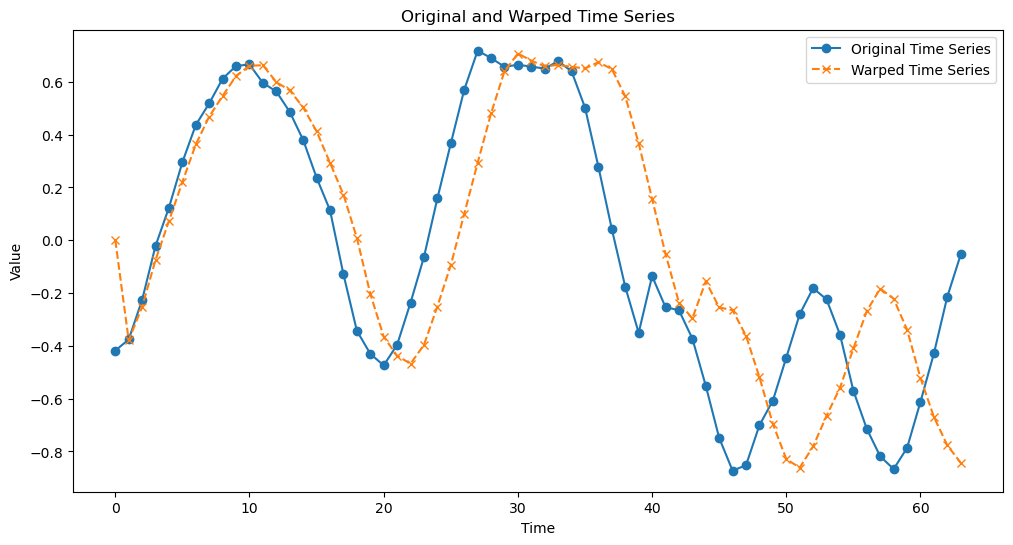

In [16]:
import matplotlib.pyplot as plt
# Apply time warping to the tensor x
warped_x = time_warping(x, 0.1)

# Select a sample index for demonstration
sample_index = 0

# Convert tensors to numpy for plotting
original_series = x[sample_index].numpy()
warped_series = warped_x[sample_index].numpy()

# Plot the original and warped time series
plt.figure(figsize=(12, 6))
# Original Time Series
plt.plot(original_series.T, label='Original Time Series', linestyle='-', marker='o')
# Warped Time Series
plt.plot(warped_series.T, label='Warped Time Series', linestyle='--', marker='x')
plt.legend()
plt.title('Original and Warped Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [5]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

RuntimeError: The size of tensor a (300) must match the size of tensor b (64) at non-singleton dimension 2

In [6]:
temporal_datasets = ['Dataset_cbf.tsds',
                     'Dataset_distalphalanxtw.tsds',
                     'Dataset_freezerregulartrain.tsds',
                     'Dataset_freezersmalltrain.tsds',
                     'Dataset_gunpointagespan.tsds',
                     'Dataset_gunpointmaleversusfemale.tsds',
                     'Dataset_gunpointoldversusyoung.tsds',
                     'Dataset_middlephalanxoutlineagegroup.tsds',
                     'Dataset_mixedshapesregulartrain.tsds',
                     'Dataset_powercons.tsds',
                     'Dataset_proximalphalanxoutlinecorrect.tsds',
                     'Dataset_selfregulationscp2.tsds',
                     'Dataset_slope.tsds',
                     'Dataset_smoothsubspace.tsds',
                     'Dataset_symbols.tsds']

In [7]:
trainset = dataset(temporal_datasets[1], args, datapath=None, mode='train', augment=False)

In [ ]:
DATASET = 0
dataset_name = temporal_datasets[DATASET]
trainset = dataset(dataname=dataset_name,
                   args=args,
                   datapath=None,
                   path=None, mode='train')

In [36]:
my_aug = (    
    tsaug.Drift(max_drift=0.2)
    +tsaug.AddNoise(scale=0.02)
)

In [9]:
trainset.X_train.size()

torch.Size([300, 1, 64])

In [10]:
torch.permute(trainset.X_train, (0, 2, 1)).size()

torch.Size([300, 64, 1])

In [24]:
sample_index = 1
torch.permute(trainset.X_train, (0, 2, 1))[sample_index].size()

torch.Size([64, 1])

/scratch/ipykernel_92635/2692499204.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series_tensor = torch.tensor(time_series, dtype=torch.float32)


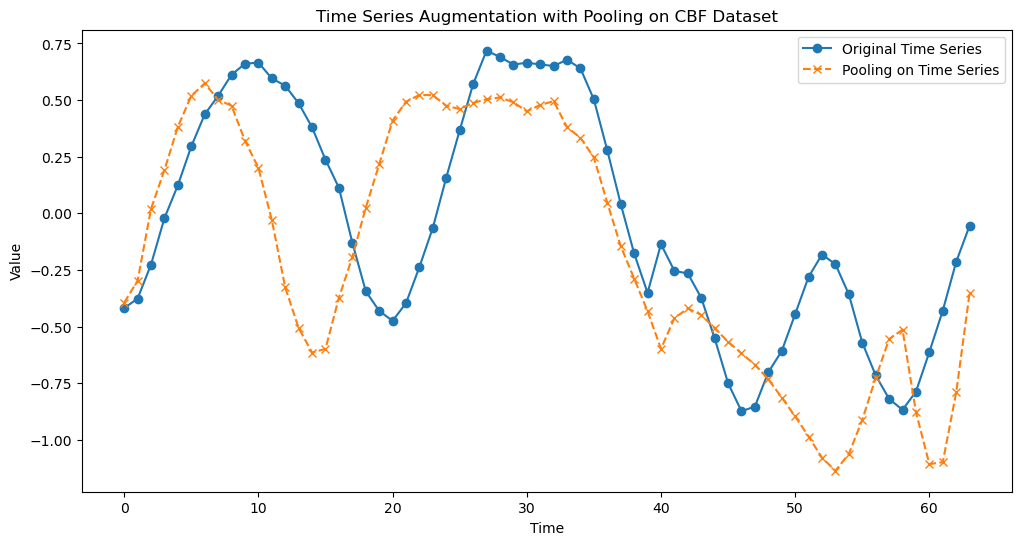

In [11]:
# Select a sample time series for demonstration
import matplotlib.pyplot as plt
sample_index = 0
time_series = torch.permute(trainset.X_train, (0, 2, 1))
# Convert the time series to a PyTorch tensor
time_series_tensor = torch.tensor(time_series, dtype=torch.float32)
# Create the Drift augmenter
drift_augmenter = tsaug.Drift(max_drift=0.1)
noise_augmenter = tsaug.AddNoise(scale=0.02)
augmenter = (
    tsaug.Drift(max_drift=0.2)
    + tsaug.AddNoise(scale=0.02)
    + tsaug.TimeWarp(n_speed_change=5, max_speed_ratio=3)
    # + tsaug.Convolve(window="flattop", size=2)
    # + tsaug.Pool(kind='ave',size=2)
)

# augmenter = tsaug.Pool(kind='ave',size=2)


# Function to apply tsaug on PyTorch tensor


def apply_tsaug_on_tensor(tensor):
    # Convert tensor to numpy
    np_array = tensor.numpy()
    # Apply the augmentation
    augmented_np_array = augmenter.augment(np_array)
    # Convert back to tensor
    augmented_tensor = torch.tensor(augmented_np_array, dtype=torch.float32)
    return augmented_tensor


# Apply the Drift augmentation
augmented_series_tensor = apply_tsaug_on_tensor(time_series_tensor)
# Convert tensors back to numpy for plotting
time_series = time_series_tensor.numpy()
augmented_series = augmented_series_tensor.numpy()
# Plot the original and drifted time series
plt.figure(figsize=(12, 6))
# Original Time Series
plt.plot(time_series[sample_index], label='Original Time Series', linestyle='-', marker='o')
# Drifted Time Series
plt.plot(augmented_series[sample_index], label=f'Pooling on Time Series', linestyle='--', marker='x')
plt.legend()
plt.title('Time Series Augmentation with Pooling on CBF Dataset')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [26]:
augmented_series.shape, time_series.shape

((1, 64), (1, 64))

In [14]:
trainset.X_train.shape, trainset.y_train.shape

(torch.Size([300, 1, 64]), torch.Size([300]))

In [18]:
torch.min(trainset.X_train)

tensor(-0.9081)

In [3]:
train_loader, datainfo  = GetDataLoader(DATASET=0, 
                    DataPath='./dataset', 
                    datapath=None, 
                    N_time=32, 
                    R_test=1, 
                    R_train=1, 
                    InputNoise=0.,
                    DEVICE='cpu',
                    task = 'temporal')
    
